# Kaggle Project: Dog Breed Identification (Playground)

[Project Page](https://www.kaggle.com/c/dog-breed-identification/data) 

In this playground competition, you are provided a strictly canine subset of ImageNet in order to practice fine-grained image categorization. How well you can tell your Norfolk Terriers from your Norwich Terriers? With 120 breeds of dogs and a limited number training images per class, you might find the problem more, err, ruff than you anticipated.

## File descriptions


* train.zip - the training set, you are provided the breed for these dogs
* test.zip - the test set, you must predict the probability of each breed for each image
* sample_submission.csv - a sample submission file in the correct format
* labels.csv - the breeds for the images in the train set

## Submission File

or each image in the test set, you must predict a probability for each of the different breeds. The file should contain a header and have the following format:

```
id,affenpinscher,afghan_hound,..,yorkshire_terrier
000621fb3cbb32d8935728e48679680e,0.0083,0.0,...,0.0083
etc.
```


In [3]:
import math
from glob import glob
import os
import random
from os import listdir
from os.path import isfile, join
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sklearn
import scipy

from sklearn.model_selection import train_test_split

%matplotlib inline



# Import Keras

from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


# Preview data labels and train/ test images

In [29]:
# Read train label data
train_labels = pd.read_csv("./input/labels.csv")
print("Number of training examples:{}".format(len(train_labels)))
train_labels.head()

Number of training examples:10222


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [30]:
# Turn train_lables to a dic
train_labels = train_labels.set_index('id')['breed'].to_dict()

In [33]:
# import breeds.txt
with open("./input/breeds.txt") as f:
    all_breeds = f.read().split('\n')[:-1]

all_breeds

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [38]:
# Set file directories
TRAIN_DIR = './input/train/'
TEST_DIR = './input/test/'
train_file_paths = [(os.path.splitext(os.path.basename(filename))[0], os.path.join(TRAIN_DIR, filename)) 
                    for filename in os.listdir(TRAIN_DIR)]

test_file_paths = [(os.path.splitext(os.path.basename(filename))[0], os.path.join(TEST_DIR, filename)) 
                    for filename in os.listdir(TEST_DIR)]


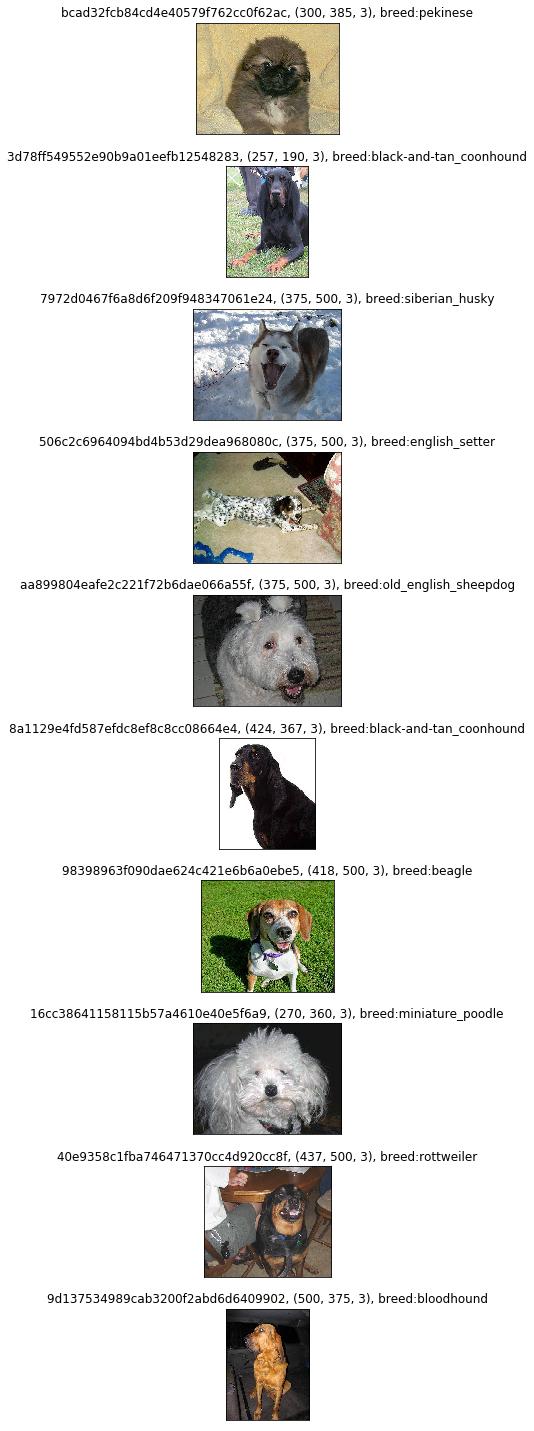

In [45]:
# Preview train images

fig, axes = plt.subplots(figsize=(20, 20), nrows=10, ncols=1)
plt.tight_layout() # Increases space between subplots

# Randomly select and display images
for ax in axes.flat:
    file_id, file_path = random.choice(train_file_paths)
    img=mpimg.imread(file_path)
    ax.imshow(img)
    ax.set_title("{}, {}, breed:{}".format(file_id, img.shape, train_labels[file_id]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

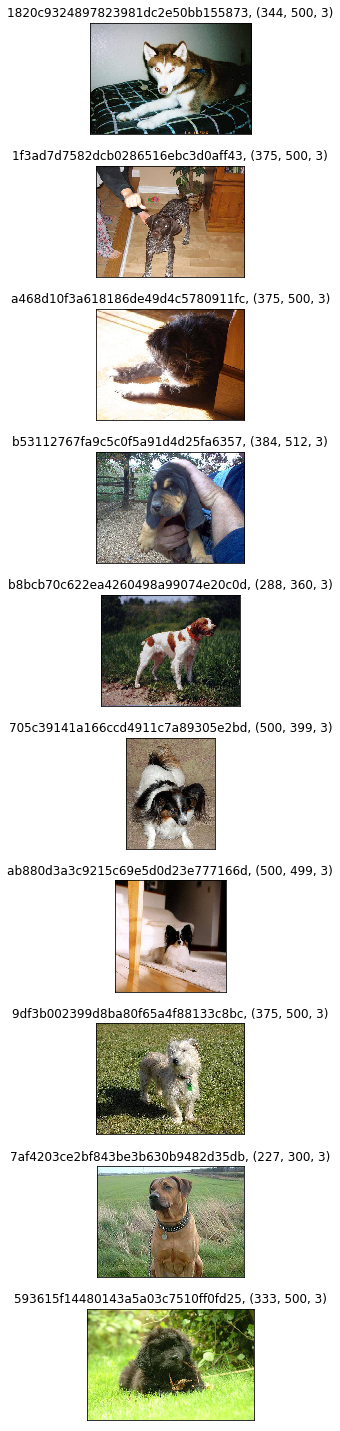

In [47]:
# Preview test images

fig, axes = plt.subplots(figsize=(20, 20), nrows=10, ncols=1)
plt.tight_layout() # Increases space between subplots

# Randomly select and display images
for ax in axes.flat:
    file_id, file_path = random.choice(test_file_paths)
    img=mpimg.imread(file_path)
    ax.imshow(img)
    ax.set_title("{}, {}".format(file_id, img.shape))b
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Prepare Data for Supervised Learning Task

## Steps

1. Convert train examples' breed info into numeric labels and one-hot encode them
2.  

In [78]:
# Setup the model using VGG16 


base_model = applications.VGG16(weights='imagenet', include_top=False, 
                                input_shape=(img_height, img_width, img_channel))

# Freeze the base model's layers from training
for layer in base_model.layers:
    layer.trainable = False



In [80]:
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dropout(0.5))
add_model.add(Dense(1, activation='sigmoid'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 244, 244, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 244, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 244, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 122, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 122, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 122, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 61, 61, 128)       0         
__________

In [81]:
# Setup datagen
batch_size = 32
epochs = 50

datagen = ImageDataGenerator(
    featurewise_center=True,
    rotation_range=30, 
    width_shift_range=0.1,
    height_shift_range=0.1, 
    horizontal_flip=True)



# Fit the generators
datagen.fit(train_img)


# Fit the model 
model.fit_generator(datagen.flow(train_img, y_train, batch_size=batch_size),
                    steps_per_epoch=train_img.shape[0] // batch_size, epochs=epochs,
                    validation_data=(val_img, y_val),
                    callbacks=[ModelCheckpoint('VGG16-transferlearning.model', monitor='val_acc', save_best_only=True)]
                   )






Epoch 1/50
 7/64 [==>...........................] - ETA: 47s - loss: 0.9400 - acc: 0.4911

KeyboardInterrupt: 

# Predict test data

In [ ]:

# Rescale test img
test_img = test_img / 255.0

